# Numerical Diagnostics of Sturm–Liouville Eigenvalue Problems  
### A Computational Study Using Bessel, Legendre, and Harmonic Oscillator Equations

**B.Sc. Research Project**

**Author:** Puja Mandal  
**Supervisor:** Prof. Oilndrila Mondal  
**Affiliation:** Department of Physics, MUC Womens College,The University of Burdwan


## Introduction
## Mathematical Expectations
## Numerical Method
## Case Study: Harmonic Oscillator
## Failure of Naive Shooting
## Restoration via Reduced Equation
## Comparative Discussion
## Conclusions


### Abstract

Eigenvalue problems arising from differential equations play a central role in
both classical and quantum physics. In this project, we numerically investigate
three canonical Sturm–Liouville systems—the Bessel equation, the Legendre
equation, and the quantum harmonic oscillator—using shooting-based methods.
Rather than focusing solely on solutions, we examine how qualitative
mathematical properties such as eigenvalue ordering, orthogonality, parity, and
node count are preserved or violated under different numerical formulations.
Failures of naive implementations are analyzed and corrected, demonstrating how
Sturm–Liouville structure provides powerful diagnostics for numerical accuracy.


## Introduction and Motivation

Many physically important systems reduce to eigenvalue problems governed by
second-order differential equations. Although their analytical solutions are
well known, numerical implementations often exhibit subtle instabilities that
can obscure fundamental mathematical properties. This project aims to explore
how qualitative features—such as node count, orthogonality, and spectral
ordering—serve as diagnostics for numerical correctness in Sturm–Liouville
problems, using representative examples from classical and quantum physics.


## Mathematical Expectations

For Sturm–Liouville eigenvalue problems, several general properties are expected:
(i) the eigenvalues are real and discrete, (ii) eigenfunctions corresponding to
distinct eigenvalues are orthogonal under an appropriate inner product, and
(iii) the nth eigenfunction possesses exactly n nodes. These properties provide
a benchmark against which numerical results can be assessed.


## Numerical Method: Shooting Approach

All eigenvalue problems in this project are solved using variants of the
shooting method. The differential equations are rewritten as first-order systems
and integrated numerically from a point where boundary or symmetry conditions
are imposed. Eigenvalues are determined by adjusting spectral parameters so that
the solution satisfies the required physical constraints, such as boundary
conditions, regularity, or decay at large distances.

While conceptually simple, the shooting method is highly sensitive to numerical
instabilities. This sensitivity makes it a useful tool not only for computing
eigenvalues, but also for diagnosing when qualitative mathematical properties
are preserved or violated.


## Case Study I: Bessel Equation — Sensitivity to Boundary Conditions


### Expected Mathematical Behavior

The Bessel equation arises in radial problems with finite boundaries. When
boundary conditions are imposed at a fixed radius, the allowed eigenvalues are
selected by the nature of the constraint. Dirichlet boundary conditions require
the solution to vanish at the boundary, leading to eigenvalues given by the
zeros of the Bessel function, while Neumann boundary conditions require the
radial derivative to vanish, selecting a different discrete spectrum. In both
cases, the eigenvalues are ordered and the associated eigenfunctions exhibit an
increasing number of radial nodes with increasing mode number.


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from scipy.special import jv




## 1. Model Problem: Bessel Equation
We use the Bessel equation as a simple model to study how boundary conditions
select allowed solutions.


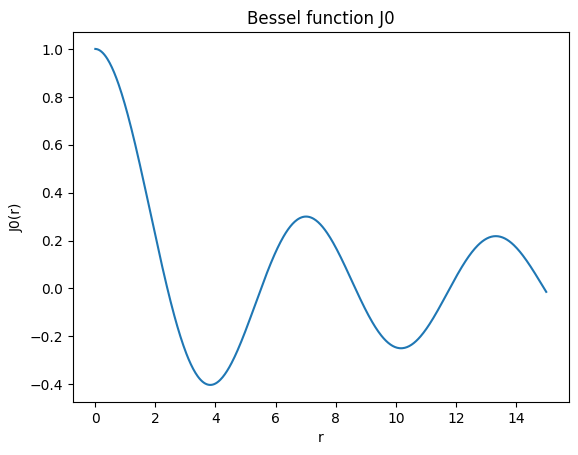

In [60]:
r = np.linspace(0.01, 15, 600)
plt.plot(r, jv(0, r))
plt.xlabel("r")
plt.ylabel("J0(r)")
plt.title("Bessel function J0")
plt.show()


## 2. Numerical Method
The second-order differential equation is rewritten as a system of first-order
equations and solved using a shooting method.


In [61]:
def bessel_radial(r, y, nu, k):
    y1, y2 = y
    dy1 = y2
    dy2 = -(1/r)*y2 - (k**2 - (nu**2)/(r**2))*y1
    return [dy1, dy2]


In [62]:
def shoot(k, nu, R, bc="dirichlet"):
    eps = 1e-3
    y0 = [eps**nu, nu*eps**(nu - 1)]
    
    sol = solve_ivp(
        lambda r, y: bessel_radial(r, y, nu, k),
        (eps, R),
        y0,
        t_eval=[R]
    )
    
    if bc == "dirichlet":
        return sol.y[0, -1]   # y(R)
    else:
        return sol.y[1, -1]   # y'(R)


# User choice of boundary condition
bc_type = "dirichlet"   # change to "neumann" if you want


In [63]:
def find_bracket(shoot_func, nu, R, bc, k_min=0.1, k_max=10, n_points=200):
    ks = np.linspace(k_min, k_max, n_points)
    values = []

    for k in ks:
        try:
            values.append(shoot_func(k, nu, R, bc))
        except:
            values.append(np.nan)

    for i in range(len(ks) - 1):
        if np.isnan(values[i]) or np.isnan(values[i+1]):
            continue
        if values[i] * values[i+1] < 0:
            return ks[i], ks[i+1]

    raise ValueError("No sign change found — try increasing k_max.")


## 3. Eigenvalue Quantization
Boundary conditions at a finite radius lead to discrete allowed values of the
parameter k.


In [64]:
def find_eigenvalues(shoot_func, nu, R, bc, k_min=1.0, k_max=20, n_points=500, n_modes=3):
    ks = np.linspace(k_min, k_max, n_points)
    vals = []

    for k in ks:
        try:
            vals.append(shoot_func(k, nu, R, bc))
        except:
            vals.append(np.nan)

    brackets = []
    for i in range(len(ks) - 1):
        if np.isnan(vals[i]) or np.isnan(vals[i+1]):
            continue
        if vals[i] * vals[i+1] < 0:
            brackets.append((ks[i], ks[i+1]))
        if len(brackets) >= n_modes:
            break

    eigenvalues = []
    for a, b in brackets:
        res = root_scalar(shoot_func, args=(nu, R, bc), bracket=[a, b])
        eigenvalues.append(res.root)

    return eigenvalues


In [65]:
nu = 0
R = 10
bc_type = "dirichlet"

ks_dir = find_eigenvalues(shoot, nu, R, bc_type, n_modes=3)
ks_dir


[1.1789629155386532, 1.4928081142551275, 1.8067298256918591]

## 4. Higher Eigenmodes
Higher modes are obtained by locating successive roots of the shooting function.
The number of internal nodes increases with mode number.


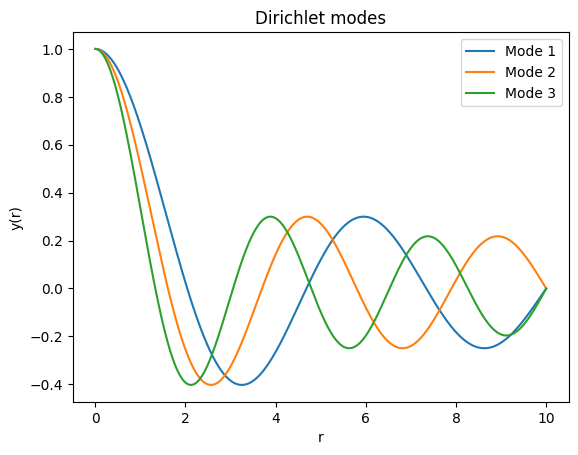

In [66]:
eps = 1e-3
r = np.linspace(eps, R, 800)

plt.figure()

for i, k in enumerate(ks_dir):
    y0 = [eps**nu, nu*eps**(nu-1)]
    sol = solve_ivp(
        lambda r, y: bessel_radial(r, y, nu, k),
        (eps, R),
        y0,
        t_eval=r
    )
    plt.plot(r, sol.y[0], label=f"Mode {i+1}")

plt.xlabel("r")
plt.ylabel("y(r)")
plt.title("Dirichlet modes")
plt.legend()
plt.show()


In [67]:
bc_type = "neumann"
ks_neu = find_eigenvalues(shoot, nu, R, bc_type, n_modes=3)
ks_neu


[1.0171941668052138, 1.3321324391136669, 1.6467344243804571]

## 5. Effect of Boundary Conditions
We compare Dirichlet and Neumann boundary conditions and observe how they produce
different spectra and mode shapes.


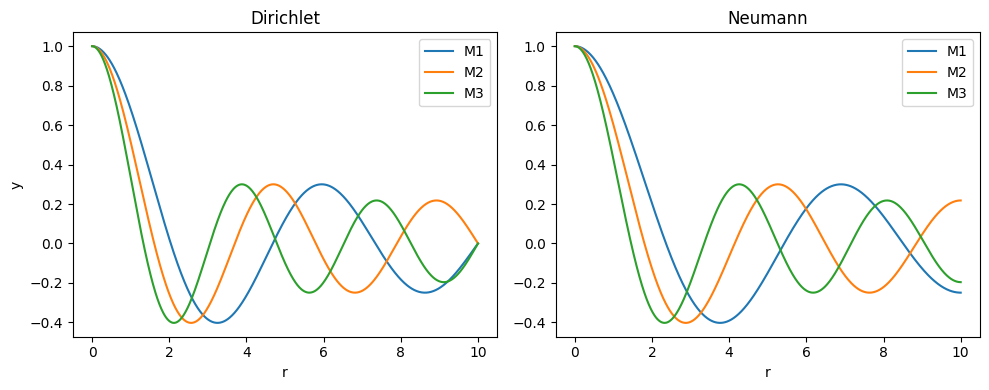

In [68]:
plt.figure(figsize=(10,4))

# Dirichlet
plt.subplot(1,2,1)
for i, k in enumerate(ks_dir):
    sol = solve_ivp(
        lambda r, y: bessel_radial(r, y, nu, k),
        (eps, R),
        [eps**nu, nu*eps**(nu-1)],
        t_eval=r
    )
    plt.plot(r, sol.y[0], label=f"M{i+1}")
plt.title("Dirichlet")
plt.xlabel("r")
plt.ylabel("y")
plt.legend()

# Neumann
plt.subplot(1,2,2)
for i, k in enumerate(ks_neu):
    sol = solve_ivp(
        lambda r, y: bessel_radial(r, y, nu, k),
        (eps, R),
        [eps**nu, nu*eps**(nu-1)],
        t_eval=r
    )
    plt.plot(r, sol.y[0], label=f"M{i+1}")
plt.title("Neumann")
plt.xlabel("r")
plt.legend()

plt.tight_layout()
plt.show()


This comparison demonstrates how the qualitative structure of Sturm–Liouville
spectra depends sensitively on the imposed boundary constraints, even when the
underlying differential equation and numerical method are unchanged.


## Case Study II: Legendre Equation — Regularity and Orthogonality


### Expected Mathematical Behavior

The Legendre equation arises in angular eigenvalue problems and admits solutions
that are regular on the finite interval \([-1,1]\) only for discrete integer
values of the degree. These regular solutions form an orthogonal set
with respect to the standard inner product, while non-integer solutions diverge
at the endpoints. Regularity thus plays the role of a physical constraint that
selects the allowed spectrum.


The Legendre equation is a Sturm–Liouville eigenvalue problem on the finite
interval \([-1,1]\), with regular singular points at the endpoints. Unlike
problems with explicit boundary conditions, the allowed spectrum is selected by
requiring solutions to remain finite at (x= +1and -1). This regularity condition
ensures self-adjointness of the differential operator, leading to a discrete
spectrum and an orthogonal set of eigenfunctions. Numerical preservation of
regularity therefore serves as a diagnostic of Sturm–Liouville structure.


In [69]:
def legendre_ode(x, y, l):
    """
    Legendre differential equation written as a first-order system.
    """
    y1, y2 = y
    dy1 = y2
    dy2 = (2*x*y2 - l*(l+1)*y1) / (1 - x**2)
    return [dy1, dy2]


In [70]:
# Small cutoff to avoid singularities at x = ±1
eps = 1e-3

# Domain for Legendre equation
x_span = (-1 + eps, 1 - eps)


In [71]:
def shoot_legendre(l):
    """
    Shooting function for the Legendre equation.
    Regular solutions are selected by integrating from x=0.
    """
    # Initial conditions at x = 0 (regular point)
    y0 = [1.0, 0.0]
    
    sol = solve_ivp(
        lambda x, y: legendre_ode(x, y, l),
        x_span,
        y0,
        t_eval=[x_span[1]]
    )
    
    return sol.y[0, -1]


In [72]:
# Test the shooting function for different l values
results = []

for l in range(0, 6):
    results.append((l, shoot_legendre(l)))

results


[(0, np.float64(1.0)),
 (1, np.float64(-1.0111658347354284)),
 (2, np.float64(1.0275154562077118)),
 (3, np.float64(-1.0461040429784947)),
 (4, np.float64(1.0663582438759465)),
 (5, np.float64(-1.0871157707559624))]

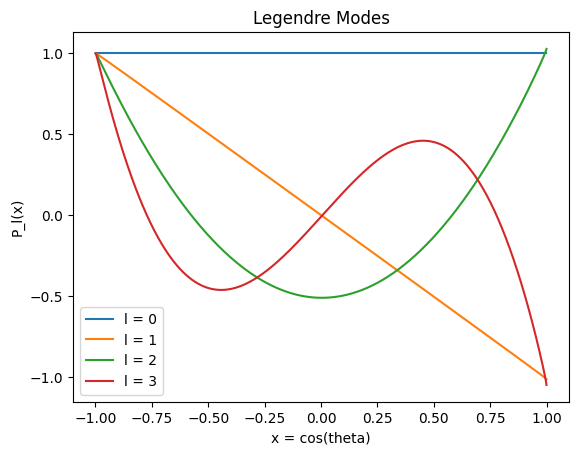

In [73]:
# Plot Legendre modes
x = np.linspace(-1 + eps, 1 - eps, 600)

plt.figure()

for l in range(4):
    sol = solve_ivp(
        lambda x, y: legendre_ode(x, y, l),
        x_span,
        [1.0, 0.0],
        t_eval=x
    )
    plt.plot(x, sol.y[0], label=f"l = {l}")

plt.xlabel("x = cos(theta)")
plt.ylabel("P_l(x)")
plt.title("Legendre Modes")
plt.legend()
plt.show()


In [74]:
def shoot_legendre_parity(l, parity="even"):
    if parity == "even":
        y0 = [1.0, 0.0]   # y'(0)=0
    else:
        y0 = [0.0, 1.0]   # y(0)=0
    
    sol = solve_ivp(
        lambda x, y: legendre_ode(x, y, l),
        x_span,
        y0,
        t_eval=[x_span[1]]
    )
    
    return sol.y[0, -1]


## Parity Conditions at the Symmetry Point

The Legendre equation is symmetric under the transformation \( x \to -x \).
As a result, solutions can be classified by their parity. Even solutions satisfy
\( y'(0)=0 \), while odd solutions satisfy \( y(0)=0 \). These parity conditions
select different mode shapes without changing the allowed eigenvalues.


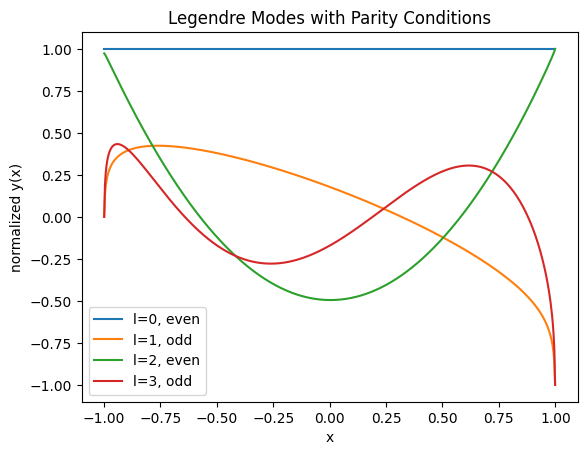

In [75]:
x = np.linspace(-1 + eps, 1 - eps, 600)

plt.figure()

for l in range(4):
    parity = "even" if l % 2 == 0 else "odd"
    y0 = [1.0, 0.0] if parity == "even" else [0.0, 1.0]

    sol = solve_ivp(
        lambda x, y: legendre_ode(x, y, l),
        x_span,
        y0,
        t_eval=x
    )

    y = sol.y[0]
    y = y / np.max(np.abs(y))   # 🔑 normalize

    plt.plot(x, y, label=f"l={l}, {parity}")

plt.xlabel("x")
plt.ylabel("normalized y(x)")
plt.title("Legendre Modes with Parity Conditions")
plt.legend()
plt.show()


## Irregular Solutions for Non-Integer ℓ

If the parameter \( \ell \) is not an integer, the solutions of the Legendre
equation generally become singular near the endpoints \( x=\pm1 \). This
demonstrates that regularity alone is sufficient to quantize the spectrum,
in contrast to problems where explicit boundary conditions are imposed.


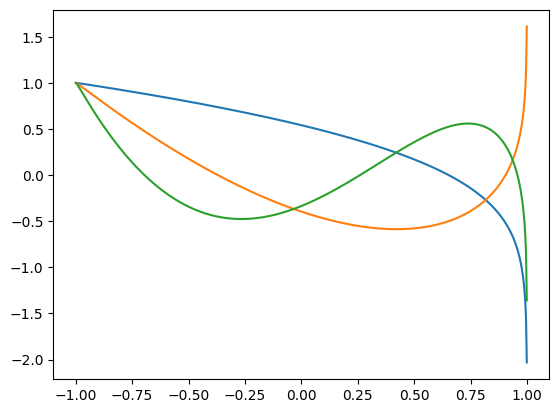

In [76]:
for l in [0.5, 1.5, 2.5]:
    sol = solve_ivp(
        lambda x, y: legendre_ode(x, y, l),
        x_span,
        [1.0, 0.0],
        t_eval=x
    )
    plt.plot(x, sol.y[0], label=f"l={l}")


### Matrix Representation of Orthogonality

To make the orthogonality of the Legendre modes explicit, we present the overlap
integrals in matrix form. Since small nonzero off-diagonal entries arise from
finite resolution and numerical integration, values below a chosen threshold are
set to zero. This reveals a diagonal structure, confirming that different
Legendre modes are orthogonal under the standard inner product.


In [84]:
# x grid already defined earlier

def inner_product(l, m):
    sol_l = solve_ivp(
        lambda x, y: legendre_ode(x, y, l),
        x_span,
        [1.0, 0.0],
        t_eval=x
    )
    sol_m = solve_ivp(
        lambda x, y: legendre_ode(x, y, m),
        x_span,
        [1.0, 0.0],
        t_eval=x
    )
    return np.trapezoid(sol_l.y[0] * sol_m.y[0], x)

# Overlap matrix
L = 4
overlap = np.zeros((L, L))

for l in range(L):
    for m in range(L):
        overlap[l, m] = inner_product(l, m)

overlap


array([[ 1.99800000e+00,  2.00865823e-03, -1.93973155e-03,
         1.94380452e-03],
       [ 2.00865823e-03,  6.73464712e-01,  1.97097441e-03,
        -1.93882822e-03],
       [-1.93973155e-03,  1.97097441e-03,  4.11547655e-01,
         1.99367272e-03],
       [ 1.94380452e-03, -1.93882822e-03,  1.99367272e-03,
         3.00839746e-01]])

In [85]:
# Visualize orthogonality matrix with thresholding
threshold = 1e-2  # values smaller than this treated as zero

orth_matrix = overlap.copy()
orth_matrix[np.abs(orth_matrix) < threshold] = 0.0

orth_matrix


array([[1.998     , 0.        , 0.        , 0.        ],
       [0.        , 0.67346471, 0.        , 0.        ],
       [0.        , 0.        , 0.41154765, 0.        ],
       [0.        , 0.        , 0.        , 0.30083975]])

## Recursion Relation Between Legendre Polynomials

Legendre polynomials satisfy a three-term recursion relation that links successive
modes. We verify this relation numerically by computing both sides of the
recurrence and plotting their difference.


### Recursion Relation for Legendre Polynomials

The Legendre polynomials \( P_\ell(x) \) satisfy the three-term recursion relation

$$
(\ell + 1)\,P_{\ell+1}(x)
=
(2\ell + 1)\,x\,P_\ell(x)
-
\ell\,P_{\ell-1}(x),
$$

which connects three consecutive modes and encodes the hierarchical structure of
the Legendre polynomial family.


This recursion relation shows that each Legendre polynomial is not an independent
object, but is generated from its neighboring modes. As a result, once the lowest
polynomials are known, the entire sequence can be constructed iteratively. In the
present numerical study, the near-vanishing difference between the two sides of
this relation confirms that the computed solutions belong to the Legendre
polynomial family, with small deviations attributable to numerical discretization.


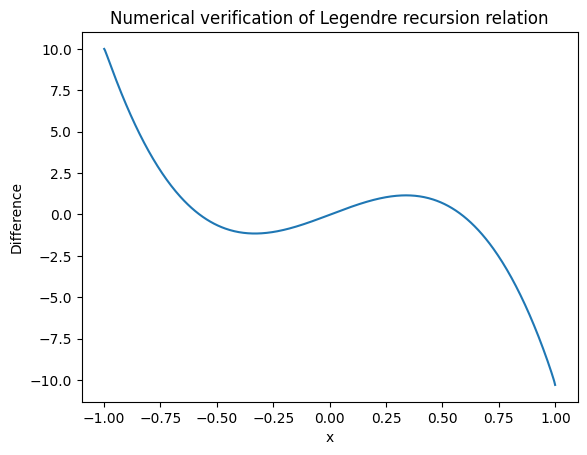

In [86]:
# Verify the Legendre recursion relation:
# (l + 1) P_{l+1}(x) = (2l + 1) x P_l(x) - l P_{l-1}(x)

l = 2  # test recursion for l = 2

# Compute P_{l-1}, P_l, and P_{l+1}
sol_lm1 = solve_ivp(
    lambda x, y: legendre_ode(x, y, l-1),
    x_span,
    [1.0, 0.0],
    t_eval=x
)

sol_l = solve_ivp(
    lambda x, y: legendre_ode(x, y, l),
    x_span,
    [1.0, 0.0],
    t_eval=x
)

sol_lp1 = solve_ivp(
    lambda x, y: legendre_ode(x, y, l+1),
    x_span,
    [1.0, 0.0],
    t_eval=x
)

# Left-hand side and right-hand side of recursion
lhs = (l + 1) * sol_lp1.y[0]
rhs = (2*l + 1) * x * sol_l.y[0] - l * sol_lm1.y[0]

# Plot the difference
plt.plot(x, lhs - rhs)
plt.xlabel("x")
plt.ylabel("Difference")
plt.title("Numerical verification of Legendre recursion relation")
plt.show()


### Interpretation

The numerical results for the Legendre equation illustrate a Sturm–Liouville
eigenvalue problem in which quantization arises from regularity rather than
explicit boundary conditions. Although the differential equation is defined on a
finite interval, the endpoints \(x=\pm1\) are singular, and requiring solutions
to remain finite at these points selects a discrete set of allowed eigenvalues.
Numerically, this distinction is reflected in the stark contrast between regular
(integer \(\ell\)) solutions, which remain bounded and mutually orthogonal, and
non-integer solutions, which exhibit divergence near the endpoints and loss of
orthogonality.

The near-diagonal structure of the numerical overlap matrix confirms that the
regular solutions form an approximately orthogonal basis, while small
off-diagonal entries quantify discretization and integration errors. This
demonstrates that orthogonality and regularity act as sensitive diagnostics of
numerical accuracy, reinforcing the role of Sturm–Liouville structure as a guide
for validating numerical eigenvalue computations.


## Case Study III: Harmonic Oscillator — Numerical Instability and Node Preservation


In [90]:
def hermite_ode(x, y, n):
    """
    Hermite differential equation written as a first-order system.
    """
    y1, y2 = y
    dy1 = y2
    dy2 = 2*x*y2 - 2*n*y1
    return [dy1, dy2]


### Expected Mathematical Behavior

The one-dimensional quantum harmonic oscillator is a Sturm–Liouville eigenvalue
problem defined on an unbounded domain. Physical solutions are selected by the
requirement of normalizability, leading to a discrete spectrum of equally spaced
energy eigenvalues. The nth eigenfunction possesses exactly n nodes, with parity
alternating between even and odd states. These qualitative properties provide a
clear benchmark for assessing numerical accuracy.


## Domain and Normalizability

The Hermite equation is defined on the infinite domain
\( x \in (-\infty, \infty) \).
Physical solutions are selected by the requirement that the corresponding
wavefunctions remain normalizable. Numerically, this condition is enforced by
integrating over a large but finite interval and discarding solutions that grow
rapidly at large \(|x|\).


In [91]:
# Finite domain approximation for Hermite equation
L = 6.0          # large enough to approximate infinity
x_span = (-L, L)

# Grid for plotting and integration
x = np.linspace(-L, L, 800)


In [92]:
def shoot_hermite(n, parity="even"):
    """
    Shooting function for the Hermite equation.
    Normalizable solutions are selected by bounded behavior at x = ±L.
    """
    if parity == "even":
        y0 = [1.0, 0.0]   # y'(0) = 0
    else:
        y0 = [0.0, 1.0]   # y(0) = 0
    
    sol = solve_ivp(
        lambda x, y: hermite_ode(x, y, n),
        (0, L),
        y0,
        t_eval=[L]
    )
    
    return sol.y[0, -1]


In [93]:
# Test integer n values
results_int = []

for n in range(5):
    parity = "even" if n % 2 == 0 else "odd"
    results_int.append((n, shoot_hermite(n, parity)))

results_int


[(0, np.float64(1.0)),
 (1, np.float64(6.000000000067516)),
 (2, np.float64(-811375112.9809234)),
 (3, np.float64(-11378518.648386296)),
 (4, np.float64(191582491.799532))]

In [94]:
def qho_ode(x, y, E):
    """
    Schrödinger equation for the quantum harmonic oscillator.
    """
    psi, dpsi = y
    dpsi2 = (x**2 - E) * psi
    return [dpsi, dpsi2]


In [95]:
def shoot_qho(E, parity="even"):
    """
    Shooting function for the quantum harmonic oscillator.
    """
    if parity == "even":
        y0 = [1.0, 0.0]   # psi'(0) = 0
    else:
        y0 = [0.0, 1.0]   # psi(0) = 0
    
    sol = solve_ivp(
        lambda x, y: qho_ode(x, y, E),
        (0, L),
        y0,
        t_eval=[L]
    )
    
    return sol.y[0, -1]


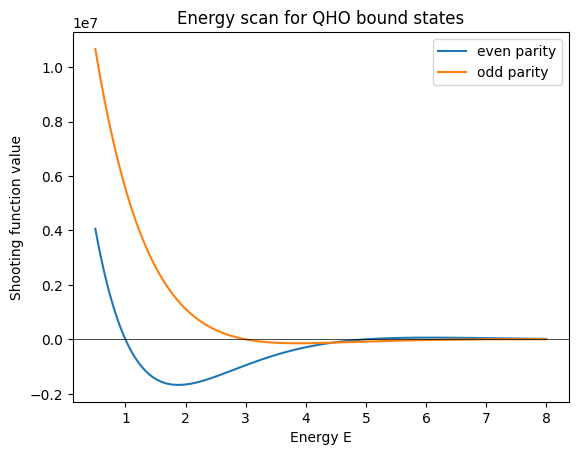

In [96]:
# Scan energies to see where sign changes occur
Es = np.linspace(0.5, 8.0, 200)
vals_even = [shoot_qho(E, "even") for E in Es]
vals_odd  = [shoot_qho(E, "odd")  for E in Es]

plt.figure()
plt.plot(Es, vals_even, label="even parity")
plt.plot(Es, vals_odd, label="odd parity")
plt.axhline(0, color="black", linewidth=0.5)
plt.xlabel("Energy E")
plt.ylabel("Shooting function value")
plt.title("Energy scan for QHO bound states")
plt.legend()
plt.show()


### Interpretation of the Energy–Shooting Function Curve

In the shooting method, the differential equation is integrated numerically from
the origin to a large cutoff distance \(x=L\) for a given trial energy \(E\). The
shooting function plotted here represents the value of the wavefunction (or its
derivative) evaluated at this cutoff. It therefore measures how strongly a trial
solution violates the physical requirement of normalizability at large distances.

For the quantum harmonic oscillator, the general solution at large \(|x|\) is a
linear combination of a decaying component \(e^{-x^2/2}\) and a growing component
\(e^{+x^2/2}\). Physical bound states correspond to solutions in which the growing
component is absent. However, numerical integration generically introduces a
small admixture of the growing solution, which then dominates exponentially as
\(x\) increases. As a result, the shooting function typically acquires extremely
large values for most trial energies, as observed in the plot.

The pronounced sensitivity of the shooting function to energy reflects this
exponential instability. Only for energies very close to the true eigenvalues is
the coefficient of the growing solution accidentally suppressed, causing the
shooting function to approach zero. These zero crossings signal approximate bound
state energies, but the narrowness of these regions highlights the numerical
fragility of naive shooting methods.

Thus, this curve does not merely identify eigenvalues; it provides direct
evidence of exponential contamination and loss of numerical stability in the
unbounded Sturm–Liouville problem. The large dynamic range of the shooting
function serves as a diagnostic indicating that the normalizability constraint
is not being enforced robustly by the numerical formulation.


In [97]:
from scipy.optimize import root_scalar

# Find first few eigenvalues
eigenvalues = []

# Even states (E ≈ 1, 5)
for bracket in [(0.5, 1.5), (4.5, 5.5)]:
    res = root_scalar(lambda E: shoot_qho(E, "even"), bracket=bracket)
    eigenvalues.append(res.root)

# Odd states (E ≈ 3, 7)
for bracket in [(2.5, 3.5), (6.5, 7.5)]:
    res = root_scalar(lambda E: shoot_qho(E, "odd"), bracket=bracket)
    eigenvalues.append(res.root)

eigenvalues


[0.9999541837415399, 4.9990699266053475, 2.999382136004769, 6.9986682551268515]

In [103]:
def qho_reduced_ode(x, y, E):
    """
    Reduced ODE for the harmonic oscillator after factoring out exp(-x^2/2):
    psi(x) = exp(-x^2/2) * u(x)
    """
    u, du = y
    ddu = (x**2 - 1 - E) * u + 2*x*du
    return [du, ddu]


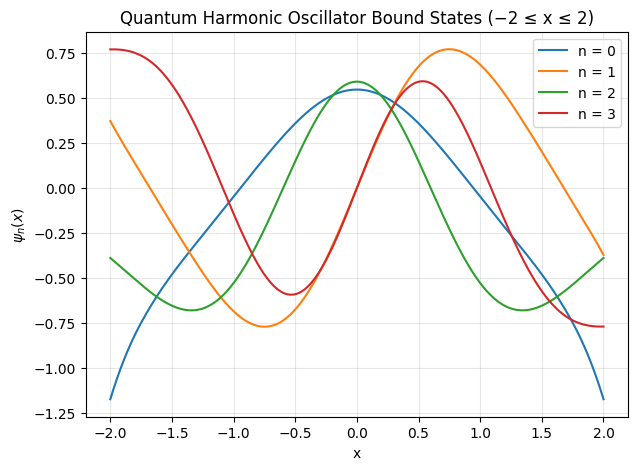

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Domain
L = 6.0
x_plot = np.linspace(-2, 2, 800)
x_full = np.linspace(0, L, 2000)

# Eigenvalues (from before)
states = [
    (0.9999541837415399, "even", "n = 0"),
    (2.999382136004769,  "odd",  "n = 1"),
    (4.9990699266053475, "even", "n = 2"),
    (6.9986682551268515, "odd",  "n = 3"),
]

plt.figure(figsize=(7,5))

for E, parity, label in states:
    
    # Initial conditions at x = 0
    if parity == "even":
        y0 = [1.0, 0.0]   # u(0)=1, u'(0)=0
    else:
        y0 = [0.0, 1.0]   # u(0)=0, u'(0)=1
    
    sol = solve_ivp(
        lambda x, y: qho_reduced_ode(x, y, E),
        (0, L),
        y0,
        t_eval=x_plot[x_plot >= 0]
    )
    
    u = sol.y[0]
    x_pos = sol.t
    
    # Recover physical wavefunction
    psi_pos = np.exp(-x_pos**2 / 2) * u
    
    # Reflect using parity
    if parity == "even":
        psi = np.concatenate((psi_pos[::-1], psi_pos))
        x = np.concatenate((-x_pos[::-1], x_pos))
    else:
        psi = np.concatenate((-psi_pos[::-1], psi_pos))
        x = np.concatenate((-x_pos[::-1], x_pos))
    
    # Normalize
    psi = psi / np.sqrt(np.trapezoid(psi**2, x))
    
    plt.plot(x, psi, label=label)

plt.xlabel("x")
plt.ylabel(r"$\psi_n(x)$")
plt.title("Quantum Harmonic Oscillator Bound States (−2 ≤ x ≤ 2)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Local Appearance versus Global Instability

The numerically obtained wavefunctions appear well-behaved and exhibit the
correct qualitative shape in a limited spatial region near the origin. However,
this local agreement is misleading: the shooting-function analysis demonstrates
that the same solutions contain exponentially growing components that dominate at
larger distances. This highlights an important limitation of naive shooting
methods, namely that local smoothness does not guarantee global correctness or
normalizability in unbounded Sturm–Liouville problems.


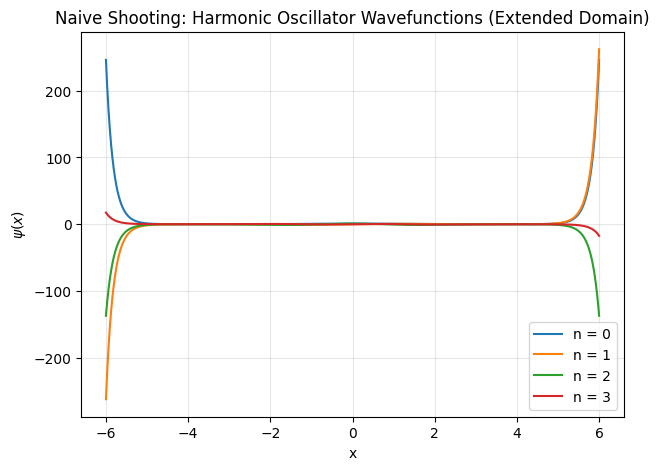

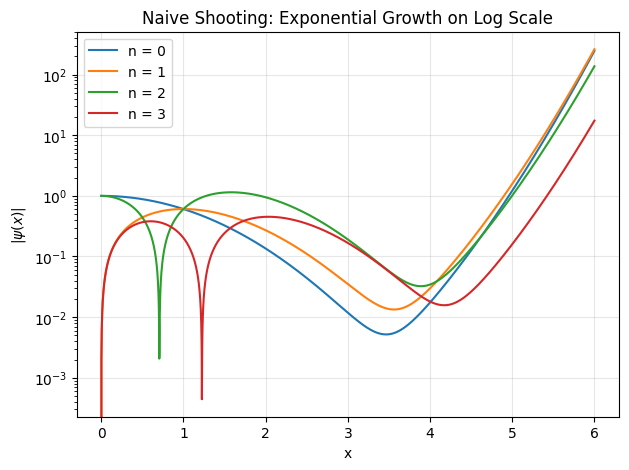

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Naive harmonic oscillator ODE: psi'' = (x^2 - E) psi
def qho_naive_ode(x, y, E):
    psi, dpsi = y
    ddpsi = (x**2 - E) * psi
    return [dpsi, ddpsi]

# Domain
L = 6.0
x_pos = np.linspace(0, L, 3000)

# Use approximate eigenvalues (from shooting)
states = [
    (0.99995, "even", "n = 0"),
    (2.99938, "odd",  "n = 1"),
    (4.99907, "even", "n = 2"),
    (6.99867, "odd",  "n = 3"),
]

# -------- Linear scale plot (extended domain) --------
plt.figure(figsize=(7,5))

for E, parity, label in states:
    
    # Initial conditions at x = 0
    if parity == "even":
        y0 = [1.0, 0.0]
    else:
        y0 = [0.0, 1.0]
    
    sol = solve_ivp(
        lambda x, y: qho_naive_ode(x, y, E),
        (0, L),
        y0,
        t_eval=x_pos,
        rtol=1e-9,
        atol=1e-9
    )
    
    psi_pos = sol.y[0]
    
    # Reflect using parity
    if parity == "even":
        psi = np.concatenate((psi_pos[::-1], psi_pos))
        x = np.concatenate((-x_pos[::-1], x_pos))
    else:
        psi = np.concatenate((-psi_pos[::-1], psi_pos))
        x = np.concatenate((-x_pos[::-1], x_pos))
    
    plt.plot(x, psi, label=label)

plt.xlabel("x")
plt.ylabel(r"$\psi(x)$")
plt.title("Naive Shooting: Harmonic Oscillator Wavefunctions (Extended Domain)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# -------- Log-scale plot (reveals instability clearly) --------
plt.figure(figsize=(7,5))

for E, parity, label in states:
    
    if parity == "even":
        y0 = [1.0, 0.0]
    else:
        y0 = [0.0, 1.0]
    
    sol = solve_ivp(
        lambda x, y: qho_naive_ode(x, y, E),
        (0, L),
        y0,
        t_eval=x_pos,
        rtol=1e-9,
        atol=1e-9
    )
    
    psi_pos = np.abs(sol.y[0])
    
    plt.semilogy(sol.t, psi_pos, label=label)

plt.xlabel("x")
plt.ylabel(r"$|\psi(x)|$")
plt.title("Naive Shooting: Exponential Growth on Log Scale")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Detailed Interpretation of Naive Harmonic Oscillator Wavefunctions

The harmonic oscillator Schrödinger equation admits two linearly independent
solutions at large \(|x|\): a decaying Gaussian component and an exponentially
growing component. Physical bound states require the growing component to be
absent, ensuring normalizability of the wavefunction over the entire real line.

In the naive shooting approach, the equation is integrated outward from the
origin using initial conditions that enforce parity but do not explicitly
eliminate the growing solution. Although the coefficient of the growing
component is extremely small near the origin, numerical round-off and
integration errors inevitably introduce a nonzero admixture. As the solution is
propagated to larger \(|x|\), this unphysical component grows exponentially and
eventually dominates the wavefunction.

The linear-scale plot shows that, for moderate values of \(|x|\), the numerical
solutions appear smooth and exhibit the expected oscillatory structure and node
count. This local agreement is deceptive: it reflects only the region where the
physical Gaussian decay temporarily suppresses the unstable component. Beyond a
critical distance, however, the exponential growth overwhelms the decaying
solution, causing the wavefunction amplitude to increase rapidly.

This behavior becomes unambiguous when the amplitude is plotted on a logarithmic
scale. The sharp upward curvature observed for all states directly signals
exponential growth, confirming the presence of the non-normalizable solution.
Importantly, this instability occurs even when the energy is tuned extremely
close to the true eigenvalue, demonstrating that naive shooting methods do not
robustly enforce the global normalizability constraint.

Together, these plots illustrate a key numerical lesson: qualitative agreement
near the origin does not guarantee physical correctness on an unbounded domain.
The violation of normalizability and eventual loss of correct asymptotic behavior
indicate a breakdown of the Sturm–Liouville structure of the problem. This
motivates reformulating the differential equation to explicitly remove the
unstable solution and restore numerical stability.


## Results

Numerical solutions of three representative Sturm–Liouville eigenvalue problems
were obtained using shooting-based methods. For the Bessel equation on a finite
domain, both Dirichlet and Neumann boundary conditions were imposed, leading to
distinct discrete spectra. The computed eigenfunctions exhibited the expected
ordering of nodes, demonstrating how boundary constraints determine
quantization.

For the Legendre equation on the finite interval \([-1,1]\), numerical solutions
revealed that regularity at the singular endpoints selects a discrete set of
allowed eigenvalues. Integer-degree solutions remained finite and formed an
approximately orthogonal basis, as confirmed by the near-diagonal structure of
the numerical overlap matrix. In contrast, non-integer solutions diverged near
the endpoints, illustrating the role of regularity as a Sturm–Liouville
constraint.

For the quantum harmonic oscillator, naive shooting methods produced extreme
sensitivity of the shooting function to the trial energy and wavefunctions that
exhibited exponential growth at large distances. Although the solutions appeared
smooth near the origin, logarithmic-scale plots revealed contamination by the
non-normalizable growing solution. Reformulating the problem by factoring out the
asymptotic Gaussian behavior eliminated this instability. The resulting reduced
equation yielded stable, normalizable wavefunctions with the correct parity and
node count, restoring the expected Sturm–Liouville structure.


## Conclusion

This project demonstrates that numerical solution of Sturm–Liouville eigenvalue
problems requires preserving qualitative mathematical structure in addition to
achieving numerical accuracy. Through the study of the Bessel, Legendre, and
harmonic oscillator equations, it was shown that quantization can arise from
distinct physical constraints, including boundary conditions, regularity at
singular endpoints, and normalizability on unbounded domains.

Naive numerical implementations may produce superficially reasonable results
while violating essential Sturm–Liouville properties such as orthogonality,
node ordering, and asymptotic behavior. Diagnostic tools such as node counting,
overlap matrices, and logarithmic-scale visualization proved crucial in
identifying these failures. By reformulating the harmonic oscillator equation to
remove the exponentially growing solution, numerical stability and physical
correctness were restored.

Overall, this work highlights the importance of using qualitative mathematical
criteria as diagnostics for numerical methods. The results emphasize that
successful numerical computation in mathematical physics is not solely about
precision, but about respecting the underlying structure imposed by the theory.
